In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from copy import deepcopy
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler                                     
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from scipy.spatial import distance
from skbio.stats.ordination import pcoa
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import umap
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

# Compare R2 for RF model with species-level prediction between w/ and w/o weights

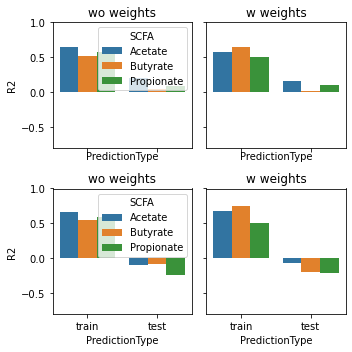

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5,5), sharex=True, sharey=True)

predictor='species'
for j,is_weight_used in enumerate([False,True]):
    if is_weight_used:
        df = pd.read_csv('rf_prediction_predictor_%s_w_weights.csv'%(predictor), index_col=0)
    else:
        df = pd.read_csv('rf_prediction_predictor_%s_wo_weights.csv'%(predictor), index_col=0)

    # calculate R2
    df_r2 = []
    for scfa in ['Acetate','Butyrate','Propionate']:
        for perturbationtype in ['intrapolation','extrapolation']:
            for predictiontype in ['train','test']:
                df_tmp = df[(df.SCFA==scfa) & (df.PerturbationType==perturbationtype) & (df.PredictionType==predictiontype)]
                df_r2.append([scfa, perturbationtype, predictiontype, r2_score(df_tmp.ObservedValue, df_tmp.PredictedValue)])
    df_r2 = pd.DataFrame(df_r2, columns=['SCFA','PerturbationType','PredictionType','R2'])

    # plot
    _ = sns.barplot(x='PredictionType', y='R2', hue='SCFA', data=df_r2[df_r2.PerturbationType=='intrapolation'], ax=ax[0,j], ci=None)
    _ = sns.barplot(x='PredictionType', y='R2', hue='SCFA', data=df_r2[df_r2.PerturbationType=='extrapolation'], ax=ax[1,j], ci=None)

    if j==0:
        ax[0,j].set_ylabel('R2')
        ax[1,j].set_ylabel('R2')
    else:
        ax[0,j].set_ylabel(None)
        ax[0,j].legend().remove()
        ax[1,j].set_ylabel(None)
        ax[1,j].legend().remove()

    _ = ax[0,j].set_ylim([-0.8,1])
    _ = ax[0,j].set_ylim([-0.8,1])
    
    if is_weight_used:
        _ = ax[0,j].set_title('w weights')
        _ = ax[1,j].set_title('w weights')
    else:
        _ = ax[0,j].set_title('wo weights')
        _ = ax[1,j].set_title('wo weights')
    
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("comparison_w_wo_weights_predictor_species.svg", format="svg")

# Plot ROC-AUC and weighting of training samples

In [6]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Resistant starch']
df_meta = df_meta[df_meta.Day != 0] # remove day 0

# read SCFA data
df_scfa = pd.read_csv('../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance (phenotype)
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# find common samples
common_samples = list(set(df_meta.index).intersection(df_scfa.index).intersection(df_bac.index))
df_meta = df_meta.loc[common_samples]
df_scfa = df_scfa.loc[common_samples]
df_bac = df_bac.loc[common_samples]

# remove genes that are constant across all samples
df_bac = df_bac[list(df_bac.std()[df_bac.std()>0].index)]

In [7]:
def get_weights(X, Z, method=None): # X is test and Z is train
    X.loc[:, "is_z"] = 0
    Z.loc[:, "is_z"] = 1
    XZ = pd.concat([X, Z],ignore_index=False) # keep index
    labels = XZ['is_z'].values
    XZ_mat = XZ.drop('is_z', axis=1).values
     
    # test if X and Z can be distinguished
    clf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0)
    predictions = np.zeros(labels.shape)
    skf = SKF(n_splits=20, shuffle=True, random_state=0)
    for fold, (train_idx, test_idx) in enumerate(skf.split(XZ_mat, labels)):
        X_train, X_test = XZ_mat[train_idx,:], XZ_mat[test_idx,:]
        y_train, y_test = labels[train_idx], labels[test_idx]

        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_test)[:, 1] # probability that each data point is a sample from training set
        predictions[test_idx] = probs
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    
    # weight_i = p_i(X|D)/p_i(Z|D)
    predictions_Z = predictions[len(X):] # p(Z/D)
    weights = (1./predictions_Z) - 1. # p(X|D)/p(Z/D)
    weights /= np.mean(weights) # we do this to re-normalize the computed log-loss
    XZ['size'] = 4
    XZ.iloc[len(X):, XZ.columns.get_loc('size')] = 0.1 + weights*15
    
    # perform decomposition
    if method is not None:
        XZ = XZ.sort_index()
        XZ_mat = XZ.drop(['is_z','size'], axis=1).values

        # dimensionality reduction
        if method=='UMAP':
            fit = umap.UMAP(random_state=0)
            u = fit.fit_transform(XZ_mat)
            XZ_dec = pd.DataFrame(u, index=XZ.index, columns=['Axis1','Axis2'])
        elif method=='PCoA':
            dist_relab = distance.squareform(distance.pdist(XZ_mat, metric="braycurtis"))
            OrdinationResults = pcoa(dist_relab, number_of_dimensions=2)
            #print(OrdinationResults.proportion_explained)
            XZ_dec = pd.DataFrame(OrdinationResults.samples.values, index=XZ.index, columns=['Axis1','Axis2'])
        else:
            print('uknown method: %s'%(method))
            raise

        XZ_dec['is_z'] = XZ['is_z']
        XZ_dec['size'] = XZ['size']        
        return fpr, tpr, weights, XZ_dec
    else:
        return fpr, tpr, weights, XZ

## ROC-AUC

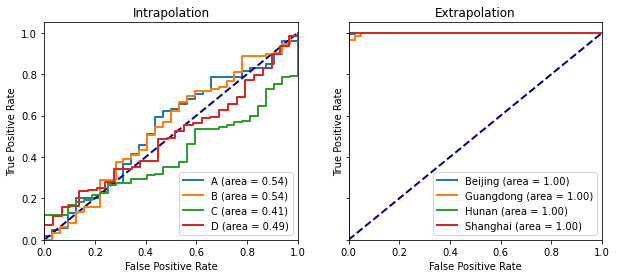

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharex=True, sharey=True)

for k,group_to_exclude in enumerate(['A','B','C','D']):

    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.RandomizedGroup!=group_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.RandomizedGroup==group_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
        
    fpr, tpr, _, _ = get_weights(X=deepcopy(xdata_test), Z=deepcopy(xdata_train), method=None)
    auc_score = auc(fpr, tpr)
    _ = ax[0].plot(fpr, tpr, lw=2, label='%s (area = %0.2f)' % (group_to_exclude, auc_score))
    if k==0:
        _ = ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = ax[0].set_xlim([0.0, 1.0])
    _ = ax[0].set_ylim([0.0, 1.05])

_ = ax[0].set_xlabel('False Positive Rate')
_ = ax[0].set_ylabel('True Positive Rate')
_ = ax[0].set_title('Intrapolation')
_ = ax[0].legend(loc="lower right")
     
for k,vendor_to_exclude in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        
    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.Vendor!=vendor_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.Vendor==vendor_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    
    fpr, tpr, _, _ = get_weights(X=deepcopy(xdata_test), Z=deepcopy(xdata_train), method=None)
    auc_score = auc(fpr, tpr)
    _ = ax[1].plot(fpr, tpr, lw=2, label='%s (area = %0.2f)' % (vendor_to_exclude, auc_score))
    if k==0:
        _ = ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = ax[1].set_xlim([0.0, 1.0])
    _ = ax[1].set_ylim([0.0, 1.05])

_ = ax[1].set_xlabel('False Positive Rate')
_ = ax[1].set_ylabel('True Positive Rate')
_ = ax[1].set_title('Extrapolation')
_ = ax[1].legend(loc="lower right")

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("roc_auc_train_test.svg", format="svg")

## weighting (PcoA1:33.44%, PCoA2:12.48%)

### PCOA

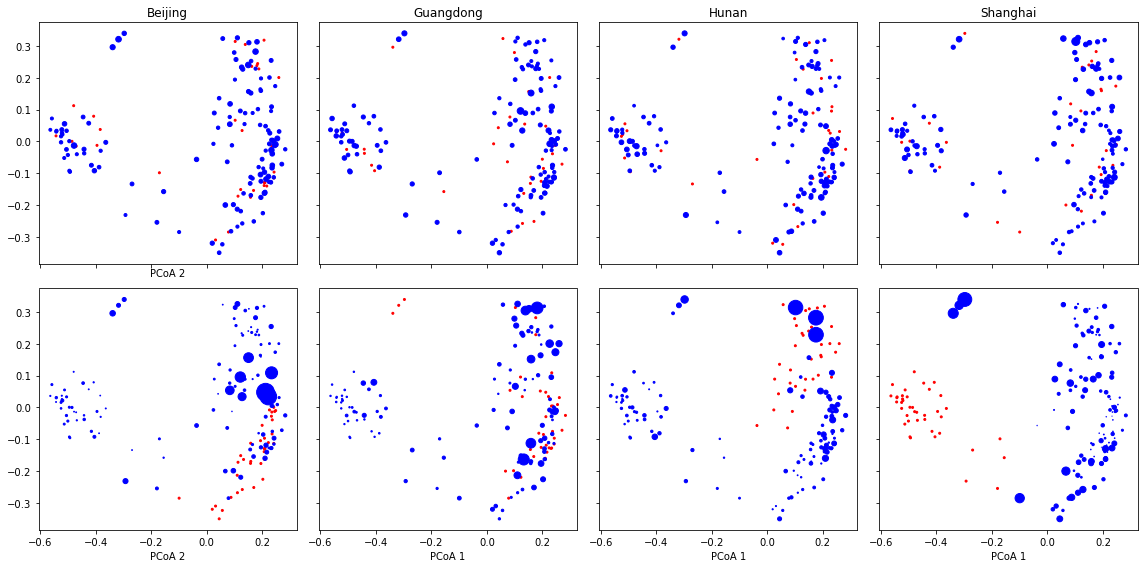

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,8), sharex=True, sharey=True)

for k,group_to_exclude in enumerate(['A','B','C','D']):

    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.RandomizedGroup!=group_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.RandomizedGroup==group_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    _, _, _, df_ord = get_weights(X=deepcopy(xdata_test), Z=deepcopy(xdata_train), method='PCoA')
     
    # show weights on train and test
    df_ord_0 = df_ord.loc[df_ord.is_z==0]
    _ = ax[0,k].scatter(df_ord_0['Axis1'], df_ord_0['Axis2'], marker='o', s=df_ord_0['size'], c='r', label='test')
    df_ord_1 = df_ord.loc[df_ord.is_z==1]
    _ = ax[0,k].scatter(df_ord_1['Axis1'], df_ord_1['Axis2'], marker='o', s=df_ord_1['size'], c='b', label='train')
    
    if k==0:
        _ = ax[0,k].set_xlabel('PCoA 2')
    _ = ax[0,k].set_title(group_to_exclude)
        
for k,vendor_to_exclude in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        
    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.Vendor!=vendor_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.Vendor==vendor_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    _, _, _, df_ord = get_weights(X=deepcopy(xdata_test), Z=deepcopy(xdata_train), method='PCoA')
        
    # show weights on train and test
    df_ord_0 = df_ord.loc[df_ord.is_z==0]
    _ = ax[1,k].scatter(df_ord_0['Axis1'], df_ord_0['Axis2'], marker='o', s=df_ord_0['size'], c='r', label='test')
    df_ord_1 = df_ord.loc[df_ord.is_z==1]
    _ = ax[1,k].scatter(df_ord_1['Axis1'], df_ord_1['Axis2'], marker='o', s=df_ord_1['size'], c='b', label='train')
    
    _ = ax[1,k].set_xlabel('PCoA 1')
    if k==0:
        _ = ax[1,k].set_xlabel('PCoA 2')
    _ = ax[0,k].set_title(vendor_to_exclude)

plt.tight_layout()

### UMAP

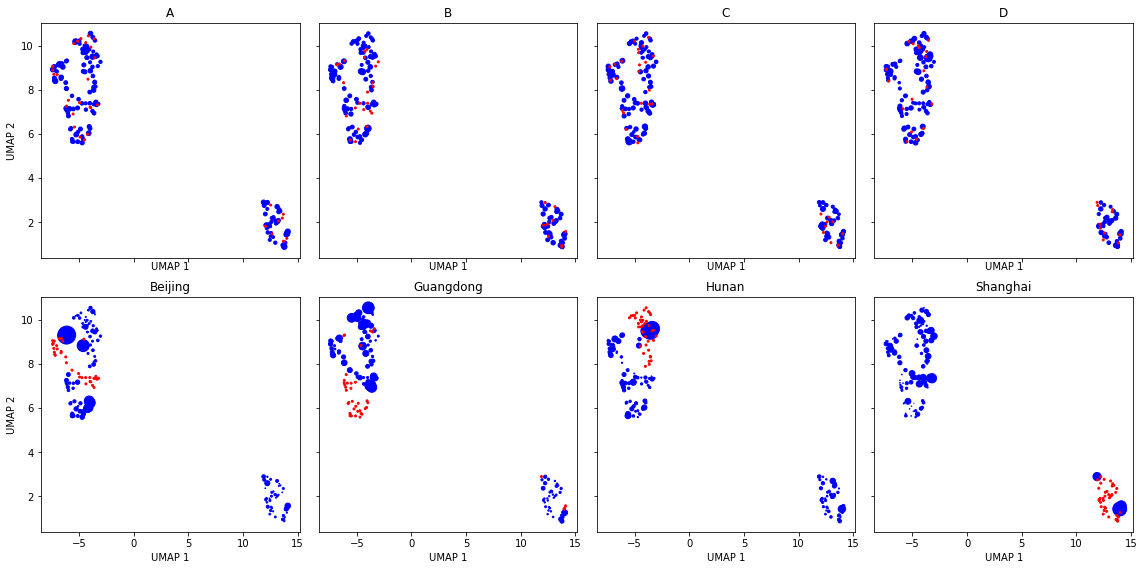

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,8), sharex=True, sharey=True)

for k,group_to_exclude in enumerate(['A','B','C','D']):

    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.RandomizedGroup!=group_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.RandomizedGroup==group_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    _, _, _, df_ord = get_weights(X=deepcopy(xdata_test), Z=deepcopy(xdata_train), method='UMAP')
     
    # show weights on train and test
    df_ord_1 = df_ord.loc[df_ord.is_z==1]
    _ = ax[0,k].scatter(df_ord_1['Axis1'], df_ord_1['Axis2'], marker='o', s=df_ord_1['size'], c='b', label='train')
    df_ord_0 = df_ord.loc[df_ord.is_z==0]
    _ = ax[0,k].scatter(df_ord_0['Axis1'], df_ord_0['Axis2'], marker='o', s=df_ord_0['size'], c='r', label='test')
        
    _ = ax[0,k].set_xlabel('UMAP 1')
    if k==0:
        _ = ax[0,k].set_ylabel('UMAP 2')
    _ = ax[0,k].set_title(group_to_exclude)
        
for k,vendor_to_exclude in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        
    # split train/test data
    mice_to_keep = list(set(df_meta[df_meta.Vendor!=vendor_to_exclude].MiceID))
    samples_to_keep = list(set(df_meta[df_meta.MiceID.isin(mice_to_keep)].index))
    mice_to_exclude = list(set(df_meta[df_meta.Vendor==vendor_to_exclude].MiceID))
    samples_to_exclude = list(set(df_meta[df_meta.MiceID.isin(mice_to_exclude)].index))

    # get weights of training sets
    xdata_train = df_bac.loc[samples_to_keep]
    xdata_test = df_bac.loc[samples_to_exclude]
    _, _, _, df_ord = get_weights(X=deepcopy(xdata_test), Z=deepcopy(xdata_train), method='UMAP')
        
    # show weights on train and test
    df_ord_1 = df_ord.loc[df_ord.is_z==1]
    _ = ax[1,k].scatter(df_ord_1['Axis1'], df_ord_1['Axis2'], marker='o', s=df_ord_1['size'], c='b', label='train')
    df_ord_0 = df_ord.loc[df_ord.is_z==0]
    _ = ax[1,k].scatter(df_ord_0['Axis1'], df_ord_0['Axis2'], marker='o', s=df_ord_0['size'], c='r', label='test')
    
    _ = ax[1,k].set_xlabel('UMAP 1')
    if k==0:
        _ = ax[1,k].set_ylabel('UMAP 2')
    _ = ax[1,k].set_title(vendor_to_exclude)

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("training_sample_weights_umap.svg", format="svg")
plt.tight_layout()

# Show scatterplot

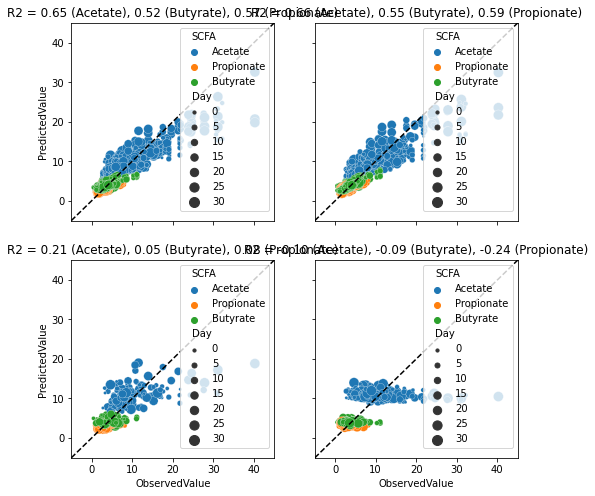

In [2]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True)

predictor = 'species'
df = pd.read_csv('rf_prediction_predictor_%s_wo_weights.csv'%(predictor), index_col=0)

for i,predictiontype in enumerate(['train','test']):
    for j,perturbationtype in enumerate(['intrapolation','extrapolation']):
        # plot data
        df_tmp = df[(df.PerturbationType==perturbationtype) & (df.PredictionType==predictiontype)]
        df_tmp['Day'] = df_tmp['Day']-1
        _ =  sns.scatterplot(x='ObservedValue', y='PredictedValue', hue='SCFA', size='Day', data=df_tmp, ax=ax[i,j], sizes=(10,100))
        # calculate R2 and add title
        r2 = []
        for scfa in ['Acetate','Butyrate','Propionate']:
            df_tmp2 = df_tmp[df_tmp.SCFA==scfa]
            r2.append(r2_score(df_tmp2.ObservedValue, df_tmp2.PredictedValue))
        _ = ax[i,j].set_title('R2 = %2.2f (%s), %2.2f (%s), %2.2f (%s)'%(r2[0], 'Acetate', r2[1], 'Butyrate', r2[2], 'Propionate'))
    
        # set xlim and ylim
        _ = ax[i,j].set_xlim([-5,45])
        _ = ax[i,j].set_ylim([-5,45])
        _ = ax[i,j].plot([-5,45],[-5,45],'k--')
        
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatter_plot_species_predictor.svg", format="svg")

# Computer species prevalence score

In [3]:
df_bac_filt = df_bac.loc[:, (df_bac != 0).any(axis=0)]
len(df_bac_filt.loc[:, (df_bac_filt != 1).any(axis=0)].columns)/len(df_bac_filt.columns)

0.8541666666666666

In [4]:
df_vendor_filt = df_bac_vendor.loc[:, (df_bac_vendor != 0).any(axis=0)]
len(df_vendor_filt.loc[:, (df_vendor_filt != 1).any(axis=0)].columns)/len(df_vendor_filt.columns)

0.7333333333333333

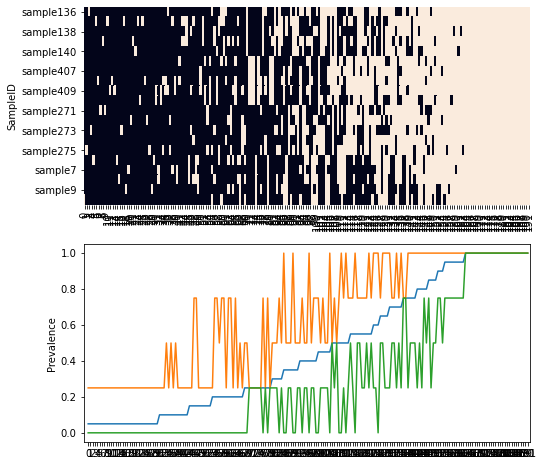

In [2]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Resistant starch']
df_meta = df_meta[df_meta.Day == 0] # baseline microbiota

# read bacterial abundance (phenotype)
df_bac = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)

# find common samples
# Beijing 5, Guangdong 5, Hunan 5, Shanghai 5
df_bac = df_bac.loc[df_meta.index]

# add mask
df_bac = (df_bac>=1e-5).astype(int)

# remove species that are not present in all baseline
df_bac = df_bac.loc[:, (df_bac != 0).any(axis=0)]

# prevalence in mice
df_bac_T = df_bac.T
df_bac_T['mean'] = df_bac_T.mean(axis=1)
df_bac_T = df_bac_T.sort_values('mean')
df_prevalence_mice = df_bac_T[['mean']].rename({'mean':'prevalence'}, axis=1)
df_prevalence_mice.to_csv('baseline_microbiota_prevalence_resistant_starch_across_mice.csv')
df_bac = df_bac_T.drop('mean', axis=1).T

# prevalence in vendor (at least one sample)
df_bac_vendor = pd.merge(df_bac, df_meta[['Vendor']], left_index=True, right_index=True, how='left').groupby('Vendor').agg('mean')
df_bac_vendor = (df_bac_vendor>1e-10).astype(int)
df_bac_vendor_T = df_bac_vendor.T
df_prevalence_vendor_at_least_one = df_bac_vendor_T.mean(axis=1).to_frame().rename({0:'prevalence'},axis=1)

# prevalence in vendor (all samples)
df_bac_vendor = pd.merge(df_bac, df_meta[['Vendor']], left_index=True, right_index=True, how='left').groupby('Vendor').agg('mean')
df_bac_vendor = (df_bac_vendor>1-1e-10).astype(int)
df_bac_vendor_T = df_bac_vendor.T
df_prevalence_vendor_all = df_bac_vendor_T.mean(axis=1).to_frame().rename({0:'prevalence'},axis=1)
df_prevalence_vendor_all.to_csv('baseline_microbiota_prevalence_resistant_starch_across_vendor.csv')

# plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
_ = sns.heatmap(df_bac, ax=ax[0], cbar=False, xticklabels=np.arange(len(df_bac.columns)))

_ = ax[1].plot(df_prevalence_mice)
_ = ax[1].plot(df_prevalence_vendor_at_least_one)
_ = ax[1].plot(df_prevalence_vendor_all)
_ = ax[1].set_xlim([-2,len(df_prevalence_mice.index)])
_ = ax[1].set_xticklabels(np.arange(len(df_prevalence_mice.index)))
_ = ax[1].set_ylabel('Prevalence')

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("baseline_presence_absence_analysis.svg", format="svg")

# Infer SCFA producers using feature selection

## Read data

In [2]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Diet=='Resistant starch']
df_meta = df_meta[df_meta.Day != 0] # remove day 0

# read SCFA data
df_scfa = pd.read_csv('../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance (asv level)
df_bac = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# find common samples
common_samples = list(set(df_meta.index).intersection(df_scfa.index).intersection(df_bac.index))
df_meta = df_meta.loc[common_samples]
df_scfa = df_scfa.loc[common_samples]
df_bac = df_bac.loc[common_samples]

# read producer labels
df_tax = pd.read_csv('../../../our_data/taxonomy_plus_scfa_producers.csv', index_col=0)

# find producer score for each species
df_producer_species = df_tax[['LowestClassifiedTaxon_Species','IsAcetateProducer','IsButyrateProducer','IsPropionateProducer']].groupby('LowestClassifiedTaxon_Species').agg(np.mean)
df_producer_species = (df_producer_species>=0.5).astype(int)

## Search for optimal hyperparameters (do not filter out nonproducers)

In [3]:
lines = []
for scfa in ['Acetate','Propionate','Butyrate']:  
    xdata_train = df_bac
    ydata_train = df_scfa[scfa]
    
    # make pipeline
    # use lasso for feature selection
    param_grid = {
        'selectfrommodel__estimator__alpha':[10**v for v in [-4,-3,-2,-1,0]], # too large alpha will produce a null model (all features are 0)
        'randomforestregressor__max_features':['auto','sqrt','log2',0.16,0.32,0.64],
        'randomforestregressor__max_depth':[2,4,8,16],
        'randomforestregressor__min_samples_split':[2,4,8,16],
        'randomforestregressor__min_samples_leaf':[1,2,4]
    }

    clf1 = linear_model.Lasso(tol=1e-5,positive=True,random_state=0,max_iter=1000000)
    clf2 = RandomForestRegressor(n_estimators=2000,random_state=0,oob_score=True)
    pipe = make_pipeline(StandardScaler(), SelectFromModel(clf1, threshold=1e-5), clone(clf2))  
    CV = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=2)
    CV.fit(np.asarray(xdata_train.values), np.asarray(ydata_train))
    
    # get selected features and importance score
    support = CV.best_estimator_[1].get_support()
    feature_names = np.array(xdata_train.columns)
    selected_feature_names = feature_names[support]
    importance_score = CV.best_estimator_[2].feature_importances_
    for f,s in zip(selected_feature_names, importance_score):
        lines.append([scfa, f, s])

    print('%s, best score and parameter combination = '%(scfa))
    print(CV.best_score_)    
    print(CV.best_params_)    
    print('\n')
    
df_feature_importance = pd.DataFrame(lines, columns=['SCFA','Species','Importance'])
df_feature_importance.to_csv('feature_importance.csv')
df_feature_importance.head()

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Acetate, best score and parameter combination = 
0.153690377406622
{'randomforestregressor__max_depth': 8, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 4, 'selectfrommodel__estimator__alpha': 0.1}


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Propionate, best score and parameter combination = 
0.14099051951693475
{'randomforestregressor__max_depth': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__min_samples_split': 2, 'selectfrommodel__estimator__alpha': 0.001}


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Butyrate, best score and parameter combination = 
0.06411033079603438
{'randomforestregressor__max_depth': 16, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomfores

,SCFA,Species,Importance
0,Acetate,Acinetobacter,0.018829
1,Acetate,Acinetobacter-sp.-CIP-56.2,0.006159
2,Acetate,Acutalibacter-muris,0.012905
3,Acetate,Akkermansia,0.002692
4,Acetate,Alistipes-finegoldii,0.013288


## Search for optimal hyperparameters (filter out nonproducers)

In [ ]:
lines = []
for scfa in ['Acetate','Propionate','Butyrate']:  
    xdata_train = df_bac[list(df_producer_species[df_producer_species['Is%sProducer'%(scfa)]==1].index)]
    ydata_train = df_scfa[scfa]
    
    # make pipeline
    # use lasso for feature selection
    param_grid = {
        'selectfrommodel__estimator__alpha':[10**v for v in [-4,-3,-2,-1,0]], # too large alpha will produce a null model (all features are 0)
        'randomforestregressor__max_features':['auto','sqrt','log2',0.16,0.32,0.64],
        'randomforestregressor__max_depth':[2,4,8,16],
        'randomforestregressor__min_samples_split':[2,4,8,16],
        'randomforestregressor__min_samples_leaf':[1,2,4]
    }

    clf1 = linear_model.Lasso(tol=1e-5,positive=True,random_state=0,max_iter=1000000)
    clf2 = RandomForestRegressor(n_estimators=2000,random_state=0,oob_score=True)
    pipe = make_pipeline(StandardScaler(), SelectFromModel(clf1, threshold=1e-5), clone(clf2))  
    CV = GridSearchCV(pipe, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=2)
    CV.fit(np.asarray(xdata_train.values), np.asarray(ydata_train))
    
    # get selected features and importance score
    support = CV.best_estimator_[1].get_support()
    feature_names = np.array(xdata_train.columns)
    selected_feature_names = feature_names[support]
    importance_score = CV.best_estimator_[2].feature_importances_
    for f,s in zip(selected_feature_names, importance_score):
        lines.append([scfa, f, s])

    print('%s, best score and parameter combination = '%(scfa))
    print(CV.best_score_)    
    print(CV.best_params_)    
    print('\n')
    
df_feature_importance = pd.DataFrame(lines, columns=['SCFA','Species','Importance'])
df_feature_importance.to_csv('feature_importance_filterout_nonproducers.csv')
df_feature_importance.head()

## Plot clustermap

In [13]:
df_feature_importance = pd.read_csv('feature_importance.csv', index_col=0)
df_feature_importance = pd.pivot_table(df_feature_importance, index='Species', columns='SCFA', values='Importance')
df_feature_importance[~df_feature_importance.Butyrate.notnull()]

SCFA,Acetate,Butyrate,Propionate
Species,,,
Akkermansia,0.001377,NaN,NaN
Akkermansia-muciniphila,NaN,NaN,0.132932
Alistipes-shahii,NaN,NaN,0.083502
Alistipes-sp.-N15.MGS-157,0.061210,NaN,NaN
Bacteroides-acidifaciens,NaN,NaN,0.168135
Bacteroides-caccae,NaN,NaN,0.008741
Bacteroides-caecimuris,0.061704,NaN,0.075616
Bacteroides-faecichinchillae,0.005401,NaN,0.000000
Bacteroides-sp.-Smarlab-3302398,NaN,NaN,0.000000


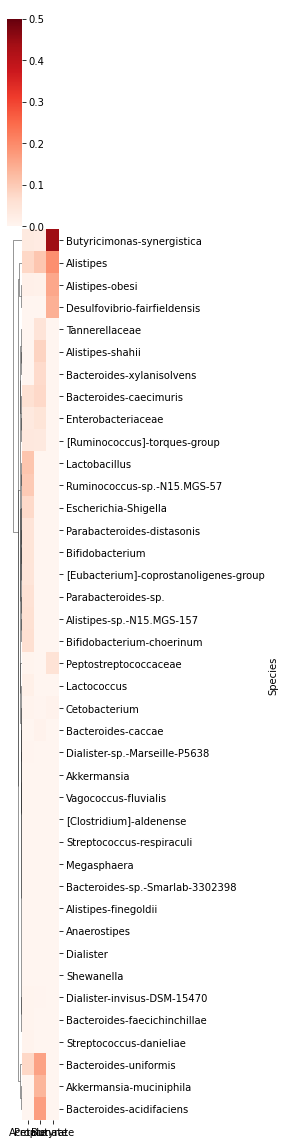

In [7]:
df_feature_importance = pd.read_csv('feature_importance.csv', index_col=0)
df_feature_importance = pd.pivot_table(df_feature_importance, index='Species', columns='SCFA', values='Importance').fillna(0)
df_feature_importance = df_feature_importance[['Acetate','Propionate','Butyrate']]

# add prevalence score
df_prevalence_mice = pd.read_csv('baseline_microbiota_prevalence_resistant_starch_across_mice.csv', index_col=0).rename({'prevalence':'prevalence_mice'}, axis=1)
df_feature_importance = pd.merge(df_feature_importance, df_prevalence_mice, left_index=True, right_index=True, how='left').fillna(0)
df_prevalence_vendor = pd.read_csv('baseline_microbiota_prevalence_resistant_starch_across_vendor.csv', index_col=0).rename({'prevalence':'prevalence_vendor'}, axis=1)
df_feature_importance = pd.merge(df_feature_importance, df_prevalence_vendor, left_index=True, right_index=True, how='left').fillna(0)

# plot clustermap
cgrid = sns.clustermap(df_feature_importance.drop(['prevalence_mice','prevalence_vendor'],axis=1),
                       col_cluster=False,
                       cmap="Reds",
                       vmin=0,
                       vmax=0.5,
                       figsize=(4,16))

plt.rcParams['svg.fonttype'] = 'none'
cgrid.savefig("scfa_producers.svg", format="svg")

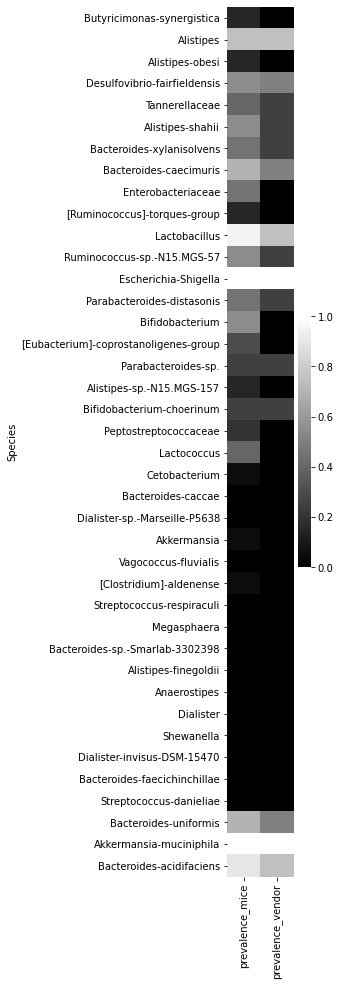

In [8]:
# plot clustermap
df_feature_importance_reordered = df_feature_importance.iloc[cgrid.dendrogram_row.reordered_ind]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.5,16))
_ = sns.heatmap(df_feature_importance_reordered[['prevalence_mice','prevalence_vendor']], cmap='gray', ax=ax)

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_producers_prevalence.svg", format="svg")